In [ ]:
!git clone https://github.com/ufoym/imbalanced-dataset-sampler

Cloning into 'imbalanced-dataset-sampler'...
remote: Enumerating objects: 4, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 38 (delta 0), reused 0 (delta 0), pack-reused 34
Unpacking objects: 100% (38/38), done.


In [ ]:
%ls

drive/  imbalanced-dataset-sampler/  sample_data/


In [ ]:
!pwd

/content


In [ ]:
%cd /content/imbalanced-dataset-sampler

/content/imbalanced-dataset-sampler


In [ ]:
!pip install .

Processing /content/imbalanced-dataset-sampler
  Created wheel for torchsampler: filename=torchsampler-0.1-cp36-none-any.whl size=3646 sha256=ec88577a99d37607c1593828668bf52f52479d8e5d1dd36db770be9d4f15709f
  Stored in directory: /root/.cache/pip/wheels/38/2b/6a/c92da1292ef596800afc50058a85ca91c768176288a586ecbe
Successfully built torchsampler


In [ ]:
%cd ..

/content


In [ ]:
!unzip -qq '/content/drive/My Drive/archive.zip'

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets


In [ ]:
from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np



In [ ]:
import copy
import random
import time

In [ ]:
SEED = 1234 #initializing seed for reproducing the results

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [ ]:
train_transforms = transforms.Compose([
                            transforms.Grayscale(num_output_channels=1),
                            transforms.Resize(224),
                            transforms.ToTensor()
                                      ])
train_data = datasets.ImageFolder(root = '/content/Alzheimer_s Dataset/train',transform=train_transforms)
RATIO = 0.7 #Ratio used for train, valid and test split
n_train_examples = int(len(train_data) * RATIO)
n_orginalvalid_examples = len(train_data) - n_train_examples
n_valid_examples = int((n_orginalvalid_examples)*0.5)
n_test_examples = n_orginalvalid_examples - n_valid_examples
print(n_train_examples)
print(n_valid_examples)
print(n_test_examples)

train_data, valid_data, test_data = data.random_split(train_data, 
                                           [n_train_examples, n_valid_examples, n_test_examples])

3584
768
769


In [ ]:
class NeuralNet(nn.Module):   #making our custom Neural Network for classification
    def __init__(self, output_dim):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels = 1, 
                               out_channels = 3, 
                               kernel_size = 5)
        
        self.conv2 = nn.Conv2d(in_channels = 3, 
                               out_channels = 3, 
                               kernel_size = 5)
        
        
        self.fc_1 = nn.Linear(10017, 5000)
        self.fc_2 = nn.Linear(5000, 250)
        self.fc_3 = nn.Linear(250, output_dim)

    def forward(self, x):
        x = self.conv1(x)
        x = F.max_pool2d(x, kernel_size = 2)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.max_pool2d(x, kernel_size = 2)
        x = F.relu(x)
        x = x.view(x.shape[0], -1)
        h = x
        x = self.fc_1(x)
        x = F.relu(x)
        x = self.fc_2(x)
        x = F.relu(x)
        x = self.fc_3(x)
        return x, h


In [ ]:
OUTPUT_DIM = 4

model = NeuralNet(OUTPUT_DIM)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 51,341,560 trainable parameters


In [ ]:
optimizer = optim.Adam(model.parameters())

In [ ]:
from torchsampler import ImbalancedDatasetSampler #Using library to so that we can avoid data Imbalance


In [ ]:
BATCH_SIZE=8
train_iterator = data.DataLoader(train_data, 
                                 sampler=ImbalancedDatasetSampler(train_data),
                                 batch_size = BATCH_SIZE)

valid_iterator = data.DataLoader(valid_data, 
                                 batch_size = BATCH_SIZE)

In [ ]:
test_iterator = data.DataLoader(test_data, batch_size = BATCH_SIZE)

In [ ]:
optimizer = optim.Adam(model.parameters(),lr=0.001)

In [ ]:
criterion = nn.CrossEntropyLoss()

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #We recommend to switch GPU on for faster training time but training using cpu also possible

In [ ]:
model = model.to(device)
criterion = criterion.to(device)

In [ ]:
device  #Ensuring CUDA is on

device(type='cuda')

In [ ]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim = True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [ ]:
#We used different function for finding training(Finding train loss and accuracy), Valid(Finding valid loss and accuracy) so that code is more legible 
def train(model, iterator, optimizer, criterion, device):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for (x, y) in iterator:
        
        x = x.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
                
        y_pred, _ = model(x)
        
        loss = criterion(y_pred, y)
        
        acc = calculate_accuracy(y_pred, y)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate(model, iterator, criterion, device):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
        
        for (x, y) in iterator:

            x = x.to(device)
            y = y.to(device)

            y_pred, _ = model(x)

            loss = criterion(y_pred, y)

            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)


def epoch_time(start_time, end_time): #function for keeping track of training time
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs





In [ ]:
#List used to store all losses and accuracy. This will be used for plotting the graph
plot_val_acc=[]
plot_train_acc=[]

plot_train_loss=[]
plot_val_loss=[]


In [ ]:
epoch_x_axis=[i for i in range(0,100)]

In [ ]:
EPOCHS = 100

best_valid_loss = float('inf')

for epoch in range(EPOCHS):
    
    start_time = time.time()
    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)
    
    #We use the given 3 lines of code to store the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut2-model.pt')
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
    plot_val_acc.append(valid_acc)
    plot_train_acc.append(train_acc)

    plot_train_loss.append(train_loss)
    plot_val_loss.append(valid_loss)
    

Epoch: 01 | Epoch Time: 0m 19s
	Train Loss: 1.018 | Train Acc: 52.96%
	 Val. Loss: 0.930 |  Val. Acc: 56.38%
Epoch: 02 | Epoch Time: 0m 18s
	Train Loss: 0.599 | Train Acc: 74.67%
	 Val. Loss: 0.744 |  Val. Acc: 66.15%
Epoch: 03 | Epoch Time: 0m 18s
	Train Loss: 0.268 | Train Acc: 90.09%
	 Val. Loss: 0.565 |  Val. Acc: 79.56%
Epoch: 04 | Epoch Time: 0m 18s
	Train Loss: 0.158 | Train Acc: 94.67%
	 Val. Loss: 0.337 |  Val. Acc: 85.81%
Epoch: 05 | Epoch Time: 0m 18s
	Train Loss: 0.089 | Train Acc: 97.15%
	 Val. Loss: 0.393 |  Val. Acc: 87.89%
Epoch: 06 | Epoch Time: 0m 18s
	Train Loss: 0.066 | Train Acc: 97.68%
	 Val. Loss: 0.361 |  Val. Acc: 88.54%
Epoch: 07 | Epoch Time: 0m 18s
	Train Loss: 0.047 | Train Acc: 98.41%
	 Val. Loss: 0.257 |  Val. Acc: 90.10%
Epoch: 08 | Epoch Time: 0m 18s
	Train Loss: 0.043 | Train Acc: 98.69%
	 Val. Loss: 0.318 |  Val. Acc: 89.06%
Epoch: 09 | Epoch Time: 0m 18s
	Train Loss: 0.034 | Train Acc: 98.88%
	 Val. Loss: 0.495 |  Val. Acc: 85.55%
Epoch: 10 | Epoch T

In [ ]:
model.load_state_dict(torch.load('tut2-model.pt'))

test_loss, test_acc = evaluate(model, test_iterator, criterion, device)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.121 | Test Acc: 98.20%


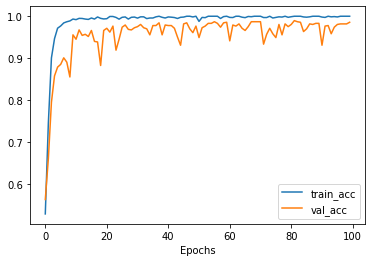

In [ ]:
plt.xlabel('Epochs')
plt.plot(epoch_x_axis,plot_train_acc,label='train_acc')
plt.plot(epoch_x_axis,plot_val_acc,label='val_acc')
# plt.plot(epoch_x_axis,plot_val_loss,label='val_loss')
# plt.plot(epoch_x_axis,plot_train_loss,label='train_loss')
plt.plot
plt.legend()
plt.show()

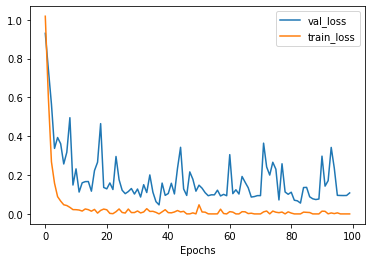

In [ ]:
plt.xlabel('Epochs')
# plt.plot(epoch_x_axis,plot_train_f1,label='train_acc')
# plt.plot(epoch_x_axis,plot_val_f1,label='train_acc')
plt.plot(epoch_x_axis,plot_val_loss,label='val_loss')
plt.plot(epoch_x_axis,plot_train_loss,label='train_loss')
plt.plot
plt.legend()
plt.show()

The below code is used to find f1 and precision

In [ ]:

def get_predictions(model, iterator):

    model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():

        for (x, y) in iterator:

            x = x.to(device)

            y_pred, _ = model(x)

            y_prob = F.softmax(y_pred, dim = -1)
            top_pred = y_prob.argmax(1, keepdim = True)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim = 0)
    labels = torch.cat(labels, dim = 0)
    probs = torch.cat(probs, dim = 0)

    return images, labels, probs

In [ ]:
images, labels, probs = get_predictions(model, test_iterator)

In [ ]:
pred_labels = torch.argmax(probs, 1)

In [ ]:
from sklearn.metrics import f1_score

In [ ]:
f1_score(labels, pred_labels, average='micro')
#We can see f1 is high enough to tell our model is performing well

0.9817945383615085

In [ ]:
from sklearn.metrics import precision_score

In [ ]:
precision_score(labels, pred_labels, average='micro')
#We can see f1 is high enough to tell our model is performing well

0.9817945383615084